In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import pandas as pd
import multiprocessing
from tqdm.notebook import trange, tqdm
from LP_run_fxns import modelRun
from LP_run_fxns import ac_sigmoid
from LP_run_fxns import ac_powerFxn

import os
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning



In [2]:
fiOutputDir = 'fiOutput'

if not os.path.exists(fiOutputDir):
    os.makedirs(fiOutputDir)

In [3]:
nProcesses = 30

Iapp = np.arange(-10,5.5,0.5)


In [4]:
statsList = ['fi_a','fi_b','fi_I0']

mechsList = ['gbar_leak_soma','gbar_a_soma','gbar_hliu_soma',
             'gbar_kca_soma','Pbar_ca_soma','gbar_mi_soma',
             'gbar_leak_axon','gbar_na_axon','gbar_k_axon',
             'tauh_na_axon',
            ]


In [5]:
def simWrapper(params,fullReturnBool = False):
    fiCurveOutput = modelRun(params = params, mechsList = mechsList, 
                             caseStr = 'fiCurve',fullReturn=fullReturnBool,
                            cvodeBool=1
                            )
   
    return {'fiCurve':fiCurveOutput,
           }
def sbiRun(params):
    outputDict = simWrapper(params)
    try:
        unpackedOutput = np.array([
                                   [[x for x in outputDict['fiCurve']['powerFitParams']]
                                   ]], dtype='object').flatten()
        statsOutput = np.concatenate(([np.array(x).flatten() for x in unpackedOutput]))
        stats = statsOutput.astype('float64')
    except:
        stats = np.array([np.nan]*len(statsList))
    
    combinedVals = params.tolist()+stats.tolist()
        
    return stats


In [6]:
def res_sbiRun(params):
    res = sbiRun(params)
    return res
def res_simWrapper(params):
    output = simWrapper(params)
    return output
def ssq_FI(params,obs_stats):
    res = sbiRun(params)
    errorVal =  obs_stats - res
    return np.sum(np.array(errorVal)**2)

pool = multiprocessing.Pool(processes=nProcesses)

/opt/miniconda/envs/neuronParamEstim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda/envs/neuronParamEstim/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/miniconda/envs/neuronParamEstim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda/envs/neuronParamEstim/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/miniconda/envs/neuronParamEstim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda/envs/neuronParamEstim/lib/python3.8/site-packages/

In [7]:
delta_gmiValsList = np.linspace(0,0.4,11)#np.linspace(0,0.32,6)
delta_gmiValsList

array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ])

In [8]:
paramsDf = pd.read_csv('fiData/paramsDf.csv')
paramsDf.drop(columns=['Unnamed: 0','Experiment','modelId'],inplace=True)
paramsDf

gbar_leak_soma  gbar_a_soma  gbar_hliu_soma  gbar_kca_soma  Pbar_ca_soma  \
0         0.503887    41.041939        3.248408      24.178030      0.473112   
1         0.337153    29.516121        1.820927      42.650375      0.523502   
2         0.241689    46.330853        2.095398      16.665180      0.273095   
3         0.303728    45.968784        1.482267      29.283175      0.228931   
4         0.264371    42.829189        4.025301      44.257046      0.563485   
..             ...          ...             ...            ...           ...   
80        0.248746    45.130539        2.171730      27.772940      0.649134   
81        0.887218    36.135586        3.117952      15.186614      0.408259   
82        0.493475    45.738110        2.270807      43.753906      0.386133   
83        0.425871    43.935593        4.117852      26.395584      0.230318   
84        0.503204    24.823933        3.194033      34.844898      0.244237   

    gbar_mi_soma  gbar_leak_axon  gbar_na_axon  gbar_k_axon  tauh_na_axon  
0       0.172202        0.000276      8.555145     0.717221     34.660500  
1       0.063793        0.000251      9.390999     0.465903     30.264351  
2       0.378550        0.000186      7.466559     0.578671     45.335384  
3       0.446322        0.000672      6.724739     0.510009     36.685211  
4       0.413794        0.000567      4.670608     0.386200     35.433945  
..           ...             ...           ...          ...           ...  
80      0.301964        0.000688      8.669103     0.441602     30.558435  
81      0.230715        0.000103      6.865655     0.383474     25.678215  
82      0.580721        0.000530      5.370966     0.423037     34.133930  
83      0.548630        0.000446      5.321892     0.507116     42.194283  
84      0.160990        0.000872      9.139386     0.420310     25.345383  

[85 rows x 10 columns]

In [9]:
%%time
gmi_sampleReturnLists = []
for delta_gmiVal in delta_gmiValsList:
    delta_mechArray = np.zeros(len(mechsList))
    delta_mechArray[5] = delta_gmiVal
    sampleReturnList_gmi = pool.starmap(res_simWrapper, zip(np.array(paramsDf)+delta_mechArray))
    
    gmi_sampleReturnLists.append(sampleReturnList_gmi)

CPU times: user 2.08 s, sys: 402 ms, total: 2.48 s
Wall time: 8min 39s


In [10]:
# gmi_sampleReturnLists = []
# gmi_sampleReturnLists.append(sampleReturnList_gmi)
# gmi_sampleReturnLists.append(sampleReturnList_gmi2)

In [11]:
import matplotlib.colors as colors
# cmap = colors.LinearSegmentedColormap.from_list("", ["black",'blue',"magenta"])
cmap = colors.LinearSegmentedColormap.from_list("", ["black",'blue'])

cMapping = np.linspace(0.2,0.8,len(delta_gmiValsList))
cMapping

array([0.2 , 0.26, 0.32, 0.38, 0.44, 0.5 , 0.56, 0.62, 0.68, 0.74, 0.8 ])

/home/omar/HDD/syncedFiles/lp_variability/paperCode/LP_run_fxns.py:15: RuntimeWarning: invalid value encountered in power
  y = a*(x-I0)**b
/home/omar/HDD/syncedFiles/lp_variability/paperCode/LP_run_fxns.py:15: RuntimeWarning: invalid value encountered in power
  y = a*(x-I0)**b
/home/omar/HDD/syncedFiles/lp_variability/paperCode/LP_run_fxns.py:15: RuntimeWarning: invalid value encountered in power
  y = a*(x-I0)**b
/home/omar/HDD/syncedFiles/lp_variability/paperCode/LP_run_fxns.py:15: RuntimeWarning: invalid value encountered in power
  y = a*(x-I0)**b
/home/omar/HDD/syncedFiles/lp_variability/paperCode/LP_run_fxns.py:15: RuntimeWarning: invalid value encountered in power
  y = a*(x-I0)**b
/home/omar/HDD/syncedFiles/lp_variability/paperCode/LP_run_fxns.py:15: RuntimeWarning: invalid value encountered in power
  y = a*(x-I0)**b
/home/omar/HDD/syncedFiles/lp_variability/paperCode/LP_run_fxns.py:15: RuntimeWarning: invalid value encountered in power
  y = a*(x-I0)**b
/home/omar/HDD/synce

CPU times: user 10.4 s, sys: 186 ms, total: 10.6 s
Wall time: 10.4 s


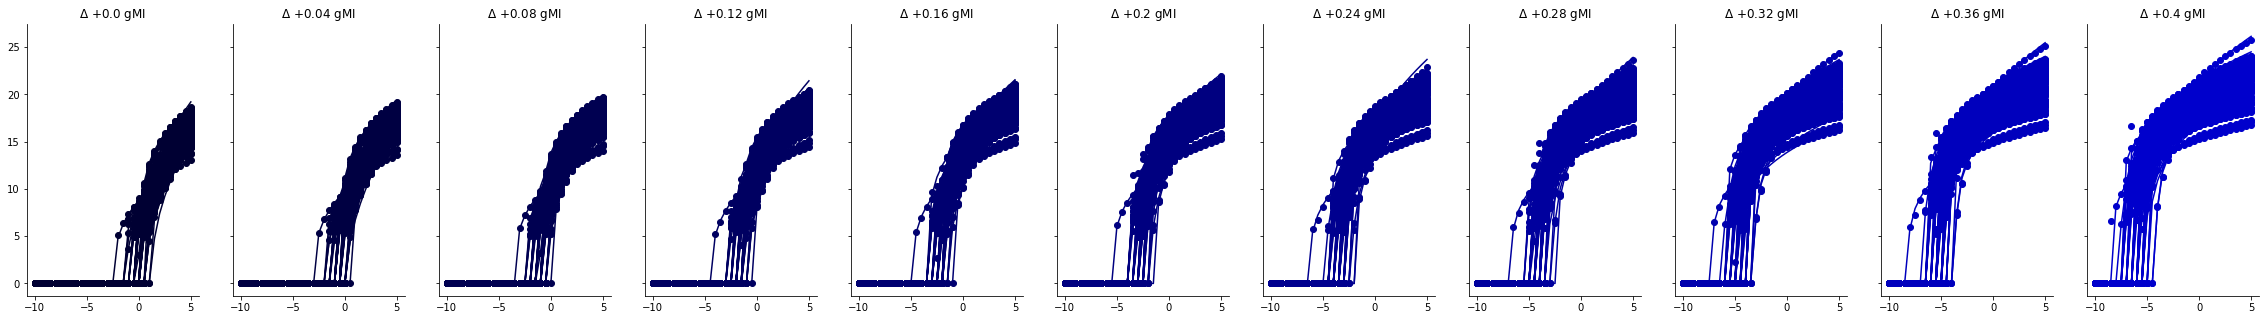

In [12]:
%%time
len(gmi_sampleReturnLists)

gmi_powerFitsList = []

aggFigs,aggAxes= plt.subplots(1,len(gmi_sampleReturnLists), figsize=(40,5), sharey=True)

fitBounds = [(None,None,None,),
             (None,None,None,)]

for gmiIdx,sampleReturnList_loop in enumerate(gmi_sampleReturnLists):
    sampleReturnDf_gmi = pd.DataFrame([x['fiCurve']['fList'] for x in sampleReturnList_loop])
    sampleReturnDf_gmi.columns=[str(val) for val in Iapp]
    # sampleReturnDf_gmi['Experiment'] = sampledParamsDf.Experiment
    aggAxes[gmiIdx].set_title(r'$\Delta$ +'+str(delta_gmiValsList[gmiIdx])+' gMI')
    c = cmap(cMapping[gmiIdx])
    # for fiIdx,fiVals in enumerate((sampleReturnDf_gmi.drop('Experiment',axis=1)).to_numpy()):
    for fiIdx,fiVals in enumerate((sampleReturnDf_gmi).to_numpy()):
    
            try:
                powerFitParams, powerFitCoVar = curve_fit(ac_powerFxn, Iapp, np.array(fiVals),bounds=fitBounds)
            except (RuntimeError,OptimizeWarning):
                try:
                    p0 = [max(fiVals), 0.5,1]
                    powerFitParams, powerFitCoVar = curve_fit(ac_powerFxn, Iapp, np.array(fiVals),p0,bounds=fitBounds)
    #                 if sum(powerFitParams) == 0:
    #                     powerFitParams = np.array([np.nan]*3)

                except(RuntimeError,OptimizeWarning):
                    powerFitParams = np.array([np.nan]*3)


            gmi_powerFitsList.append([powerFitParams,delta_gmiValsList[gmiIdx],str(int(fiIdx))])


            aggAxes[gmiIdx].scatter(Iapp,fiVals, color = c)
            aggAxes[gmiIdx].plot(Iapp,ac_powerFxn(Iapp,
                                             powerFitParams[0],
                                             powerFitParams[1],
                                             powerFitParams[2]), color = c)
sns.despine()

In [13]:
aggFigs.savefig(fiOutputDir+'/fi_curves_raw_fits.pdf')

In [14]:
gmi_powerFitsList_cleaned = [val.tolist()+[x,y] for val,x,y in gmi_powerFitsList]
gmi_powerFitsDf = pd.DataFrame(gmi_powerFitsList_cleaned, 
                               columns = ['fi_a','fi_b','fi_I0','gmi','modelId'])
gmi_powerFitsDf.to_csv(fiOutputDir+'/powerFitsCoeffs.csv')

gmi_powerFitsDf

fi_a      fi_b     fi_I0  gmi modelId
0     7.713878  0.458132  0.501425  0.0       0
1     8.166398  0.461121  1.194839  0.0       1
2     7.132042  0.495732  0.584808  0.0       2
3     8.671600  0.395586  0.681214  0.0       3
4     8.825575  0.385869  1.006748  0.0       4
..         ...       ...       ...  ...     ...
930  10.504147  0.281013 -6.453959  0.4      80
931  12.600097  0.240233 -6.067194  0.4      81
932  12.759736  0.241417 -7.097360  0.4      82
933  13.105321  0.251042 -7.079525  0.4      83
934  14.897336  0.154121 -5.118785  0.4      84

[935 rows x 5 columns]

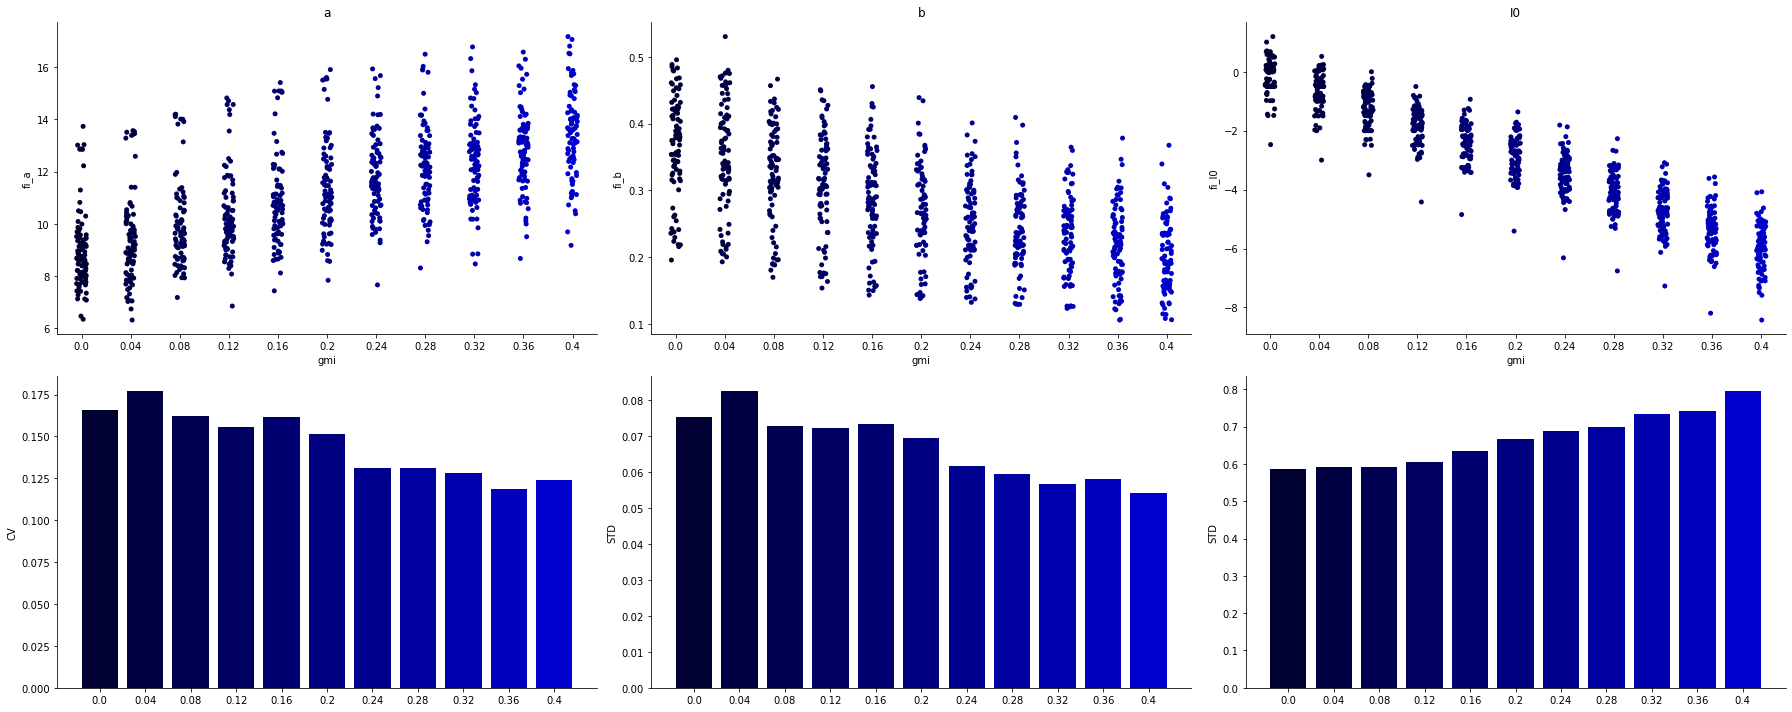

In [15]:
gmiValsStr = [str(np.round(x,3)) for x in delta_gmiValsList]
gmiValsStr

gmiFitsFig,gmiFitsAxes = plt.subplots(2,3, figsize=(25,10))



sns.stripplot(x='gmi',y='fi_a',data=gmi_powerFitsDf, 
              ax = gmiFitsAxes[0,0], palette=cmap(cMapping))
sns.stripplot(x='gmi',y='fi_b',data=gmi_powerFitsDf, 
              ax = gmiFitsAxes[0,1], palette=cmap(cMapping))
sns.stripplot(x='gmi',y='fi_I0',data=gmi_powerFitsDf, 
              ax = gmiFitsAxes[0,2], palette=cmap(cMapping))


for gmiIdx,gmiVal in enumerate(delta_gmiValsList):
    c = cmap(cMapping[gmiIdx])
    
    a_vals = gmi_powerFitsDf.fi_a[gmi_powerFitsDf.gmi==gmiVal]
    b_vals = gmi_powerFitsDf.fi_b[gmi_powerFitsDf.gmi==gmiVal]
    I0_vals = gmi_powerFitsDf.fi_I0[gmi_powerFitsDf.gmi==gmiVal]
    
    
    
    
    gmiFitsAxes[1,0].bar(x = gmiIdx, 
                       height = np.std(a_vals)/np.mean(a_vals), color = c)
    gmiFitsAxes[1,1].bar(x = gmiIdx, 
                   height = np.std(b_vals), color = c)
    gmiFitsAxes[1,2].bar(x = gmiIdx, 
               height = np.std(I0_vals), color = c)

gmiFitsAxes[1,0].set_ylabel('CV')    
gmiFitsAxes[1,1].set_ylabel('STD')    
gmiFitsAxes[1,2].set_ylabel('STD')    

gmiFitsAxes[0,0].set_title('a')    
gmiFitsAxes[0,1].set_title('b')    
gmiFitsAxes[0,2].set_title('I0') 

for gmiAxesArray in gmiFitsAxes:
    for gmiAxes in gmiAxesArray:
        gmiAxes.set_xticks(np.linspace(0,len(delta_gmiValsList)-1,len(delta_gmiValsList)))
        gmiAxes.set_xticklabels(gmiValsStr)


    
sns.despine()
plt.tight_layout()

In [16]:
gmiFitsFig.savefig(fiOutputDir+'/powerFunctionFits_vals_var_delta_gmi.pdf')